# DATASET DOWNLOAD


In [1]:
!pip install -q sentence_transformers
!pip install -q lxml


# Reading files

"BookPageMetadataSection__description" fatto
"AuthorPreview" fatto
"WorkDetails" fatto

div "BookPage__relatedTopContent" --> div "Carousel--sliderWrapper" --> li "CarouselGroup__item CarouselGroup__item--4-col" --> "BookCard__content" fatto

prendi il secondo figlio di "ReviewsList" e prendi tutti i suoi figli tranne quelli che appartengono alla classe "Ad". dentro quelli prendi tutti i tag section con class = "ReviewText__content" fatto

In [ ]:
from pathlib import Path
from bs4 import BeautifulSoup
from tqdm import tqdm
from joblib import Parallel, delayed
def html_to_text(path: Path):
 
    html = path.read_text(encoding="utf-8", errors="ignore")
    soup = BeautifulSoup(html, features="lxml")

    doc_parts = []

    # title
    div_title = soup.find("div", class_="BookPageTitleSection")
    if div_title:
        titles = div_title.find_all(recursive=False)
        for title in titles:
            doc_parts.append(title.get_text(strip=True))

    # desc
    div_desc = soup.find("div", class_="BookPageMetadataSection__description")
    if div_desc:
        desc_cell = div_desc.find(class_="Formatted")
        if desc_cell:
            doc_parts.append(desc_cell.get_text(separator=" ", strip=True))

    # author name
    div_auth = soup.find("div", class_="AuthorPreview")
    if div_auth:
        auth_name_tag = div_auth.find(class_="ContributorLink__name")
        if auth_name_tag:
            doc_parts.append(auth_name_tag.get_text(strip=True))

    # awards
    div_work = soup.find("div", class_="WorkDetails")
    if div_work:
        awards_tag = div_work.find(class_="TruncatedContent__text")
        if awards_tag:
            doc_parts.append(awards_tag.get_text(strip=True))

    # correlated books
    div_relatedbooks = soup.find("div", class_="BookPage__relatedTopContent")
    if div_relatedbooks:
        div_carousel = div_relatedbooks.find(class_="Carousel--sliderWrapper")
        if div_carousel:
            related_books_container = div_carousel.find_all("li")
            for book in related_books_container:
                book_title_tag = book.find(class_="BookCard__title")
                if book_title_tag:
                    doc_parts.append(book_title_tag.get_text(strip=True))

    # reviews
    div_reviews_list = soup.find_all("div", class_="ReviewsList")
    if len(div_reviews_list) > 1:
        div_reviews = div_reviews_list[1]
        div_reviews_children = div_reviews.find_all("div", recursive=False)

        if len(div_reviews_children) > 1:
            div_list = div_reviews_children[1]

            for ad_class in div_list.find_all(class_="Ad"):
                ad_class.decompose()

            div_review_list = div_list.find_all("div", recursive=False)
            for div_review in div_review_list:
                review_tag = div_review.find(class_="TruncatedContent__text")
                if review_tag:
                    doc_parts.append(review_tag.get_text(separator=" ", strip=True))


    final_doc = " ".join(doc_parts)
    return {
        "ID": path.stem,
        "text": final_doc
    }

files = list(Path("adm-2025-unsupervised-book-grouping/pages").glob("*.html"))
docs = Parallel(n_jobs=-1)(delayed(html_to_text)(p) for p in tqdm(files))
texts = [d["text"] for d in docs]

  0%|          | 0/1934 [00:00<?, ?it/s]

100%|██████████| 1934/1934 [00:36<00:00, 52.55it/s]


In [ ]:
import pandas as pd

df = pd.DataFrame(docs)

df.to_csv("books_dataset_cleaned.csv", index=False)

print("Dataset saved")

Dataset saved


In [ ]:
import re

# patterns di rumore molto comuni
RE_URL = re.compile(r'https?://\S+|www\.\S+')
RE_EMAIL = re.compile(r'\b[\w\.-]+@[\w\.-]+\.\w+\b')
RE_HTML_ENTITY = re.compile(r'&[a-zA-Z]+;|&#\d+;')
RE_NONWORD = re.compile(r"[^\w\sàèéìòùÀÈÉÌÒÙ'-]")  # tieni lettere accentate
RE_MULTISPACE = re.compile(r"\s+")
RE_LONG_NUM = re.compile(r"\b\d{5,}\b")  # numeri lunghi (id, hash, ecc.)
RE_FILE = re.compile(r"\b\w+\.(jpg|jpeg|png|gif|svg|pdf|epub|zip)\b", re.I)

# frasi boilerplate frequenti (personalizza se vuoi)
BOILERPLATE_PHRASES = [
    "cookie policy", "privacy policy", "terms of service", "all rights reserved",
    "copyright", "subscribe", "newsletter", "sign in", "log in"
]

def clean_for_transformer(text: str) -> str:
    t = text.lower()

    # rimuovi boilerplate frasi
    for p in BOILERPLATE_PHRASES:
        t = t.replace(p, " ")

    # rimuovi url/email/file e numeri lunghi
    t = RE_URL.sub(" ", t)
    t = RE_EMAIL.sub(" ", t)
    t = RE_FILE.sub(" ", t)
    t = RE_LONG_NUM.sub(" ", t)

    # pulizia caratteri/entità
    t = RE_HTML_ENTITY.sub(" ", t)
    t = RE_NONWORD.sub(" ", t)
    t = RE_MULTISPACE.sub(" ", t).strip()

    return t

def drop_short_lines(text: str, min_len=20) -> str:
    lines = [ln.strip() for ln in text.splitlines()]
    lines = [ln for ln in lines if len(ln) >= min_len]
    return " ".join(lines)


def shorten_words(text: str, max_words=1500) -> str:
    return " ".join(text.split()[:max_words])

#texts_clean = [shorten_words(drop_short_lines(clean_for_transformer(t)), max_words=1500) for t in texts]
texts_clean = [shorten_words(drop_short_lines(clean_for_transformer(t))) for t in texts]


# Stemming

In [ ]:
import nltk
#nltk.download("punkt")
#nltk.download("punkt_tab")
#nltk.download("wordnet")
#nltk.download("omw-1.4")
#nltk.download("stopwords")
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import string
from tqdm import tqdm

stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

def preprocess_text(text):
    tokens = word_tokenize(text.lower())

    clean_tokens = []
    for word in tokens:
        if word not in stop_words and word not in string.punctuation and len(word) > 2:
            stemmed_word = stemmer.stem(word)
            clean_tokens.append(stemmed_word)
    return " ".join(clean_tokens)

tqdm.pandas()

# Crea una nuova colonna 'text_cleaned'
df['text_cleaned'] = df['text'].progress_apply(preprocess_text)

print("Finished!")

Avvio preprocessing NLP...


100%|██████████| 1934/1934 [01:40<00:00, 19.27it/s]

Finito! Ora usa la colonna 'text_cleaned' per il TF-IDF.


# Vectorizing by semantic

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

clean_texts = df['text_cleaned'].tolist()

vectorizer = TfidfVectorizer(
    max_features=5000,      # Le 5000 parole più importanti
    min_df=5,               # Ignora parole che appaiono in meno di 5 libri
    max_df=0.9,             # Ignora parole che appaiono nel 90% dei libri (troppo comuni)
)

X = vectorizer.fit_transform(clean_texts)

print(f"Matrice creata: {X.shape}") 


Matrice creata: (1934, 5000)


In [80]:
from sklearn.decomposition import TruncatedSVD

# Scegliamo un numero di componenti (es. 100 o 200)
# Questo riduce il rumore e velocizza il clustering
lsa = TruncatedSVD(n_components=200, random_state=42)
X_lsa = lsa.fit_transform(X)

print(f"Nuova forma della matrice: {X_lsa.shape}")
print(f"Varianza spiegata: {lsa.explained_variance_ratio_.sum():.2f}")

Nuova forma della matrice: (1934, 200)
Varianza spiegata: 0.95


In [73]:
from sentence_transformers import SentenceTransformer

texts = [d["text"] for d in docs]

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
X = model.encode(texts, normalize_embeddings=True, show_progress_bar=True)



Batches: 100%|██████████| 61/61 [00:53<00:00,  1.14it/s]


# Clustering

## elbow


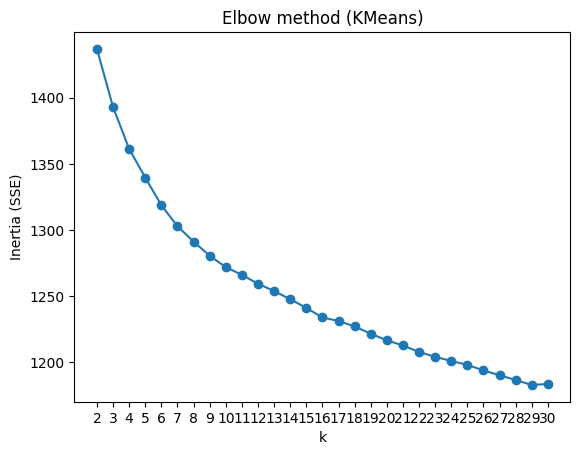

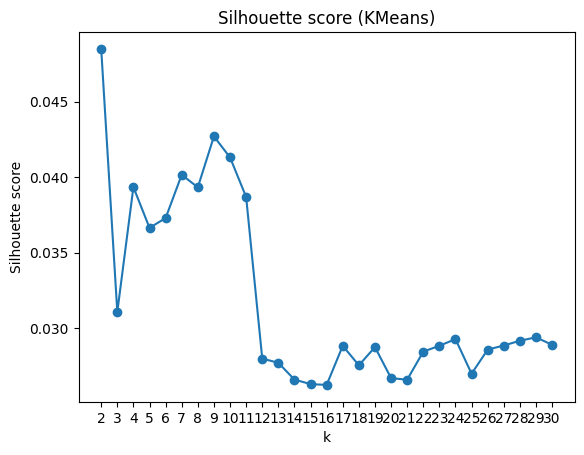

Best k (silhouette): 2


In [74]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def kmeans_elbow_silhouette(
    X,
    k_min=2,
    k_max=30,
    random_state=42,
    n_init=10,
    sample_size_for_silhouette=None,  # es. 2000 se dataset enorme
):
    """
    Calcola inertia (elbow) e silhouette score per K in [k_min, k_max].
    Ritorna: ks, inertias, silhouettes
    """
    n_samples = X.shape[0]
    if n_samples < 3:
        raise ValueError("Servono almeno 3 campioni per usare silhouette in modo sensato.")

    k_max = min(k_max, n_samples - 1)
    ks = list(range(k_min, k_max + 1))

    inertias = []
    silhouettes = []

    for k in ks:
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)

        # silhouette richiede almeno 2 cluster e < n_samples
        # (qui k>=2 e k<=n_samples-1 già garantito)
        if sample_size_for_silhouette is not None and n_samples > sample_size_for_silhouette:
            sil = silhouette_score(X, labels, sample_size=sample_size_for_silhouette, random_state=random_state)
        else:
            sil = silhouette_score(X, labels)
        silhouettes.append(sil)

    return np.array(ks), np.array(inertias), np.array(silhouettes)


# --- USO ---
# X può essere:
# - embeddings: X_emb (shape: n_libri, 384) -> numpy array
# - TF-IDF: X_tfidf (shape: n_libri, n_features) -> sparse matrix

ks, inertias, sils = kmeans_elbow_silhouette(
    X,                 # <-- metti qui la tua matrice (X_emb o X_tfidf)
    k_min=2,
    k_max=30,
    random_state=42,
    n_init=10,
    sample_size_for_silhouette=None  # oppure 2000 se hai dataset molto grande
)

# --- PLOT ELBOW ---
plt.figure()
plt.plot(ks, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow method (KMeans)")
plt.xticks(ks)
plt.show()

# --- PLOT SILHOUETTE ---
plt.figure()
plt.plot(ks, sils, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score (KMeans)")
plt.xticks(ks)
plt.show()

# --- k suggerito ---
best_k = int(ks[np.argmax(sils)])
print("Best k (silhouette):", best_k)

## autoencoder

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class AutoEncoder(nn.Module):
    def __init__(self, input_dim=384, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


In [75]:
X.shape

(1934, 384)

In [9]:
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

model = AutoEncoder(input_dim=X.shape[1], latent_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(150):
    total = 0
    for (x,) in loader:
        optimizer.zero_grad()
        x_hat = model(x)
        loss = loss_fn(x_hat, x)
        loss.backward()
        optimizer.step()
        total += loss.item()
    print(f"Epoch {epoch:02d} | loss={total/len(loader):.4f}")

Epoch 00 | loss=0.0023
Epoch 01 | loss=0.0019
Epoch 02 | loss=0.0018
Epoch 03 | loss=0.0017
Epoch 04 | loss=0.0016
Epoch 05 | loss=0.0015
Epoch 06 | loss=0.0014
Epoch 07 | loss=0.0014
Epoch 08 | loss=0.0013
Epoch 09 | loss=0.0013
Epoch 10 | loss=0.0013
Epoch 11 | loss=0.0013
Epoch 12 | loss=0.0012
Epoch 13 | loss=0.0012
Epoch 14 | loss=0.0012
Epoch 15 | loss=0.0012
Epoch 16 | loss=0.0012
Epoch 17 | loss=0.0011
Epoch 18 | loss=0.0011
Epoch 19 | loss=0.0011
Epoch 20 | loss=0.0011
Epoch 21 | loss=0.0011
Epoch 22 | loss=0.0011
Epoch 23 | loss=0.0011
Epoch 24 | loss=0.0011
Epoch 25 | loss=0.0011
Epoch 26 | loss=0.0010
Epoch 27 | loss=0.0010
Epoch 28 | loss=0.0010
Epoch 29 | loss=0.0010
Epoch 30 | loss=0.0010
Epoch 31 | loss=0.0010
Epoch 32 | loss=0.0010
Epoch 33 | loss=0.0010
Epoch 34 | loss=0.0010
Epoch 35 | loss=0.0010
Epoch 36 | loss=0.0010
Epoch 37 | loss=0.0010
Epoch 38 | loss=0.0010
Epoch 39 | loss=0.0010
Epoch 40 | loss=0.0010
Epoch 41 | loss=0.0010
Epoch 42 | loss=0.0009
Epoch 43 | 

In [10]:
with torch.no_grad():
    Z = model.encoder(X_tensor).numpy()


In [85]:
from sklearn.cluster import KMeans
k=9

# 1. Istanzia e addestra il modello (così l'oggetto 'model' conserva i centroidi)
model = KMeans(n_clusters=k, n_init=10, random_state=42)
model.fit(X)

# 2. Estrai le etichette
labels = model.labels_

# 3. (Opzionale ma utile) Salvale subito nel DataFrame
df['cluster'] = labels

## classical methods

In [67]:
from sklearn.decomposition import PCA
pca = PCA(n_components=150, random_state=42)
X_pca = pca.fit_transform(X)

print("Varianza cumulativa:", pca.explained_variance_ratio_.sum())


Varianza cumulativa: 0.86670965


In [56]:
X=X_pca

In [ ]:
from sklearn.cluster import KMeans

k = 14
labels = KMeans(n_clusters=k, n_init="auto", random_state=42).fit_predict(X)


c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [33]:
from sklearn.mixture import GaussianMixture
k=8
gmm = GaussianMixture(
    n_components=k,
    covariance_type="full",   # più flessibile (default)
    n_init=5,
    random_state=42
)

labels = gmm.fit_predict(X)

c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

# Clusters

In [73]:
import numpy as np
from collections import defaultdict

# se hai usato TF-IDF: X è sparse, vectorizer esiste
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(texts)
feature_names = np.array(vectorizer.get_feature_names_out())

cluster_top_terms = {}
for c in sorted(set(labels)):
    idx = np.where(labels == c)[0]
    centroid = X_tfidf[idx].mean(axis=0)              # (1, n_features)
    top = np.asarray(centroid).ravel().argsort()[-10:][::-1]
    cluster_top_terms[c] = feature_names[top].tolist()

cluster_top_terms

{np.int32(0): ['child goodreads',
  'reacher',
  'jack reacher',
  'lee child',
  'by lee',
  'child',
  'lee',
  'jack',
  'reacher by',
  'plan'],
 np.int32(1): ['blood',
  'bloodlines',
  'bloodlines by',
  'blue',
  'bloods',
  'blue bloods',
  'the',
  'by richelle',
  'mead',
  'mead goodreads'],
 np.int32(2): ['the',
  'goodreads the',
  'of',
  'michael',
  'by michael',
  'john',
  'by john',
  'michael connelly',
  'connelly',
  'connelly goodreads'],
 np.int32(3): ['vampire',
  'the vampire',
  'vampires',
  'the',
  'vampires by',
  'the morganville',
  'caine goodreads',
  'morganville vampires',
  'morganville',
  'rachel caine'],
 np.int32(4): ['the',
  'to',
  'and',
  'your',
  'how',
  'of',
  'you',
  'life',
  'how to',
  'for'],
 np.int32(5): ['fire',
  'sparks',
  'nicholas sparks',
  'sparks goodreads',
  'nicholas',
  'by nicholas',
  'the',
  'ashes',
  'gabriel',
  'fire by'],
 np.int32(6): ['the',
  'love',
  'goodreads the',
  'of',
  'kiss',
  'man',
  'lov

In [35]:
!pip install -q pandas

In [86]:
import pandas as pd

rows = []
for i, d in enumerate(docs):
    rows.append({
        "ID": i,
        "TARGET": int(labels[i])+1
    })

df = pd.DataFrame(rows)
df.to_csv("book_clusters.csv", index=False, encoding="utf-8")

df.head()

,ID,TARGET
0,0,3
1,1,3
2,2,3
3,3,3
4,4,3
